In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '../../shared_data/round2/'
days = [-1, 0, 1]

activity = [pd.read_csv(path + f'prices_round_2_day_{d}.csv', sep=';') for d in days]
activity = pd.concat(activity)
activity.set_index(['DAY', 'timestamp'], inplace=True)
activity.describe()

,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY
count,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000
mean,1103.617855,1.237043,9.728044,-3.405143,2777.073279,79.073562
std,81.975222,0.287521,1.368582,1.235526,912.366591,9.366057
min,960.750000,0.700000,7.500000,-6.500000,1397.304900,59.999580
25%,1039.250000,1.000000,8.500000,-4.500000,1973.018900,71.204712
50%,1081.750000,1.300000,9.500000,-2.600000,2498.066200,78.579020
75%,1195.750000,1.400000,10.500000,-2.400000,3619.445200,86.771817
max,1257.250000,2.100000,19.500000,-2.000000,4513.986300,97.513270


- Sunlight: if the sunlight exposure is less than 7 hours a day, production decreases by 4% for every 10 mins
- Humidity: ideal humidity is 60% to 80%, outsides of this range, production decreases by 2% for every 5% difference

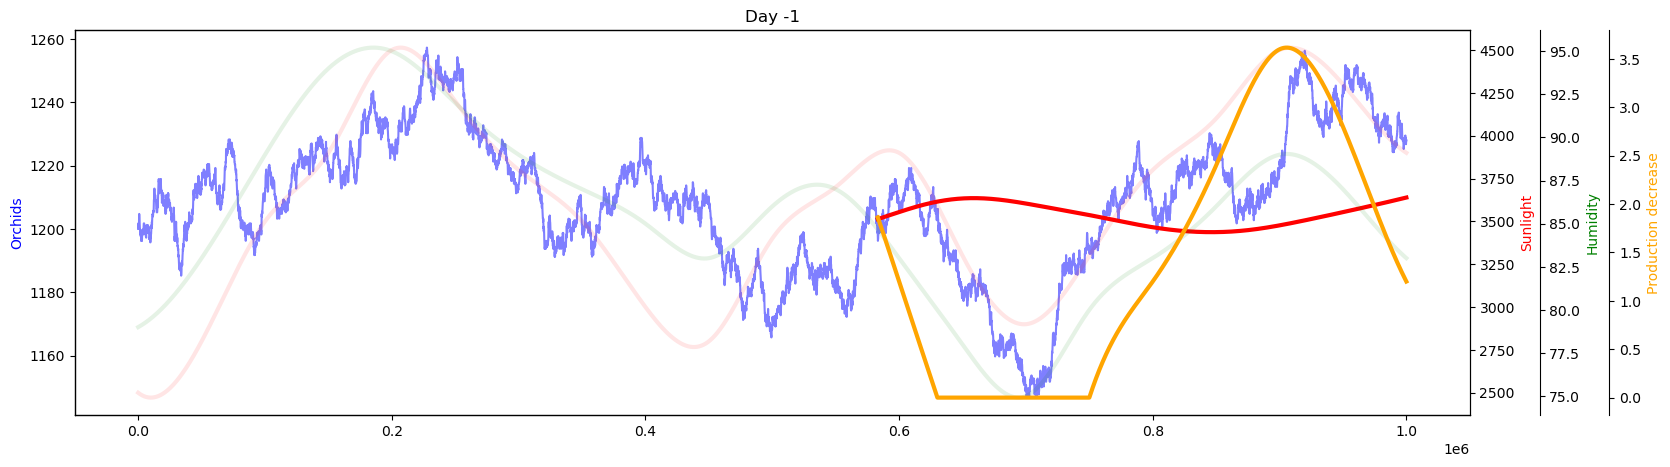

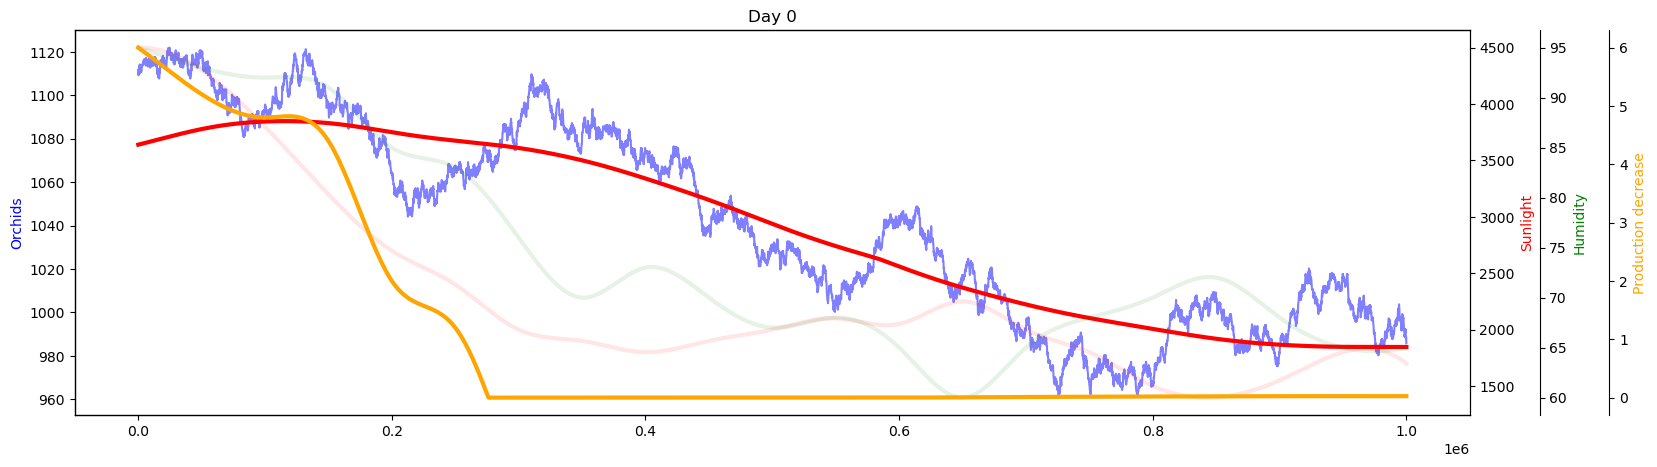

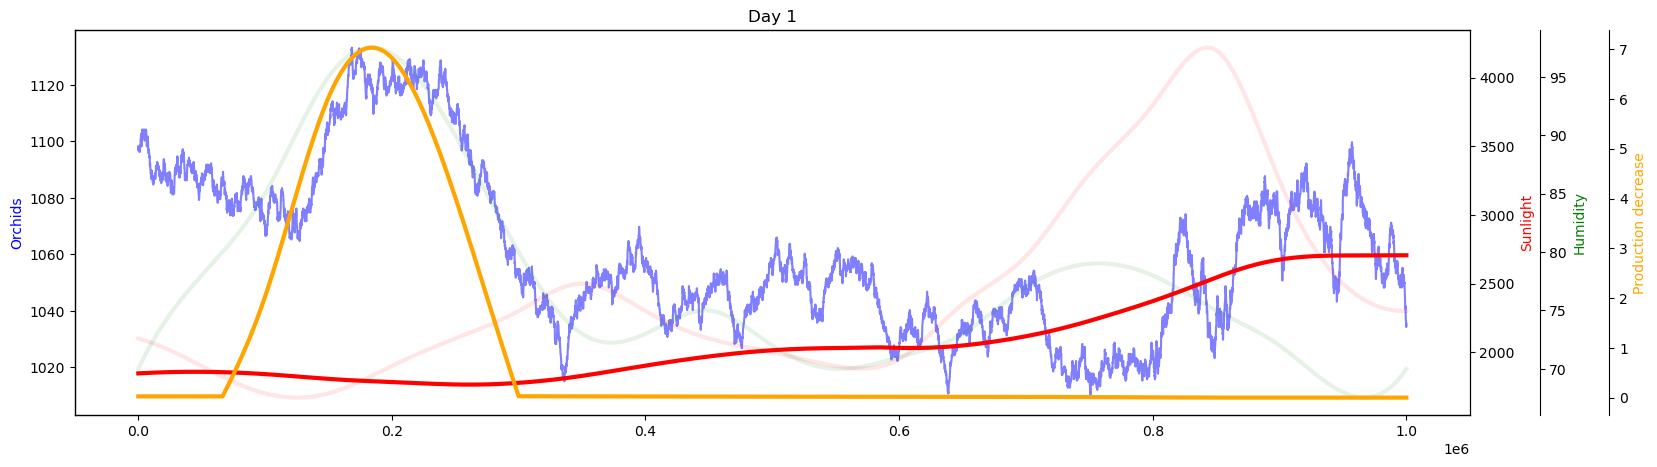

In [3]:
hourly_sunlight = 2500
avg_window = 5833

for d in days:
    price = activity.loc[d].ORCHIDS
    humidity = activity.loc[d].HUMIDITY
    sunlight = activity.loc[d].SUNLIGHT

    if d == -1:
        sunlight_avg = sunlight.rolling(avg_window).mean()
    else:
        sunlight_before = activity.loc[d-1].SUNLIGHT
        sunlight_before.index = sunlight.index - 1000_000
        sunlight_combined = pd.concat([sunlight_before, sunlight])
        sunlight_avg = sunlight_combined.rolling(avg_window).mean()
        sunlight_avg = sunlight_avg[sunlight_avg.index > 0]

    humidity_diff = 2/5 * humidity.apply(lambda x: max(x - 80, 60 - x, 0))
    sunlight_diff = 4/42 * sunlight_avg.apply(lambda x: max((1 - x/2500, 0)))

    production_dec = humidity_diff + sunlight_diff

    fig, ax1 = plt.subplots(figsize=(18, 5))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()
    ax3.spines.right.set_position(("axes", 1.05))
    ax4.spines.right.set_position(("axes", 1.1))

    ax1.plot(price, color='blue', alpha=0.5)
    ax1.set_ylabel('Orchids', color='blue')

    ax2.plot(sunlight, color='red', alpha=0.1, linewidth=3)
    ax2.plot(sunlight_avg, color='red', linewidth=3)
    ax2.set_ylabel('Sunlight', color='red')

    ax3.plot(humidity, color='green', alpha=0.1, linewidth=3)
    ax3.set_ylabel('Humidity', color='green')

    ax4.plot(production_dec, color='orange', linewidth=3)
    ax4.set_ylabel('Production decrease', color='orange')

    plt.title(f'Day {d}')
    plt.show()

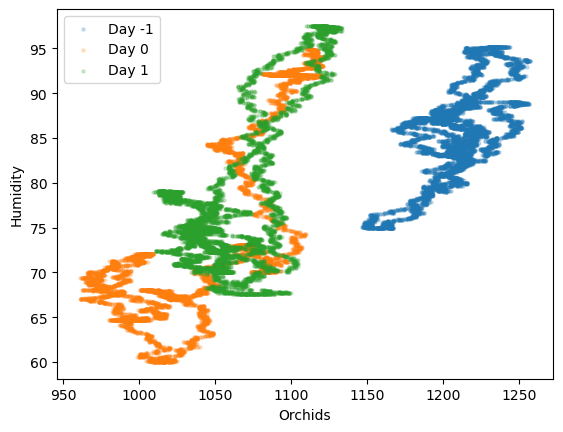

In [5]:
plt.figure()
for d in days:
    plt.scatter(activity.ORCHIDS.loc[d], activity.HUMIDITY.loc[d], label=f'Day {d}', s=5, alpha=0.2)

plt.legend()
plt.xlabel('Orchids')
plt.ylabel('Humidity')
plt.show()

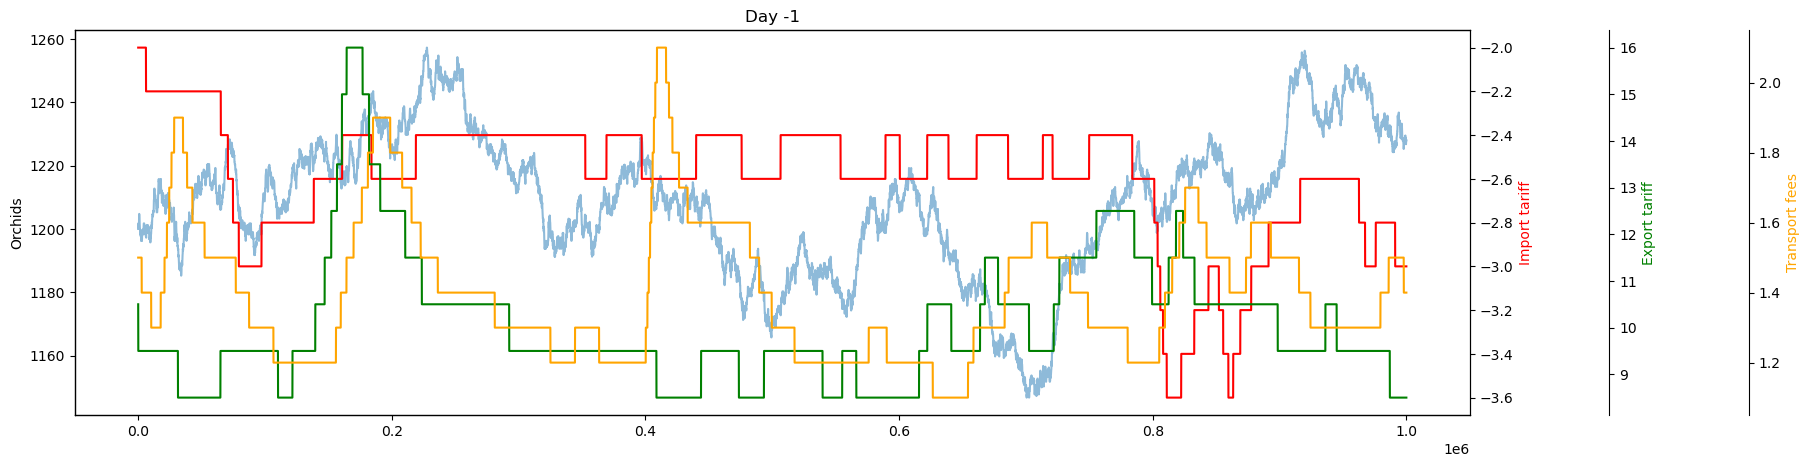

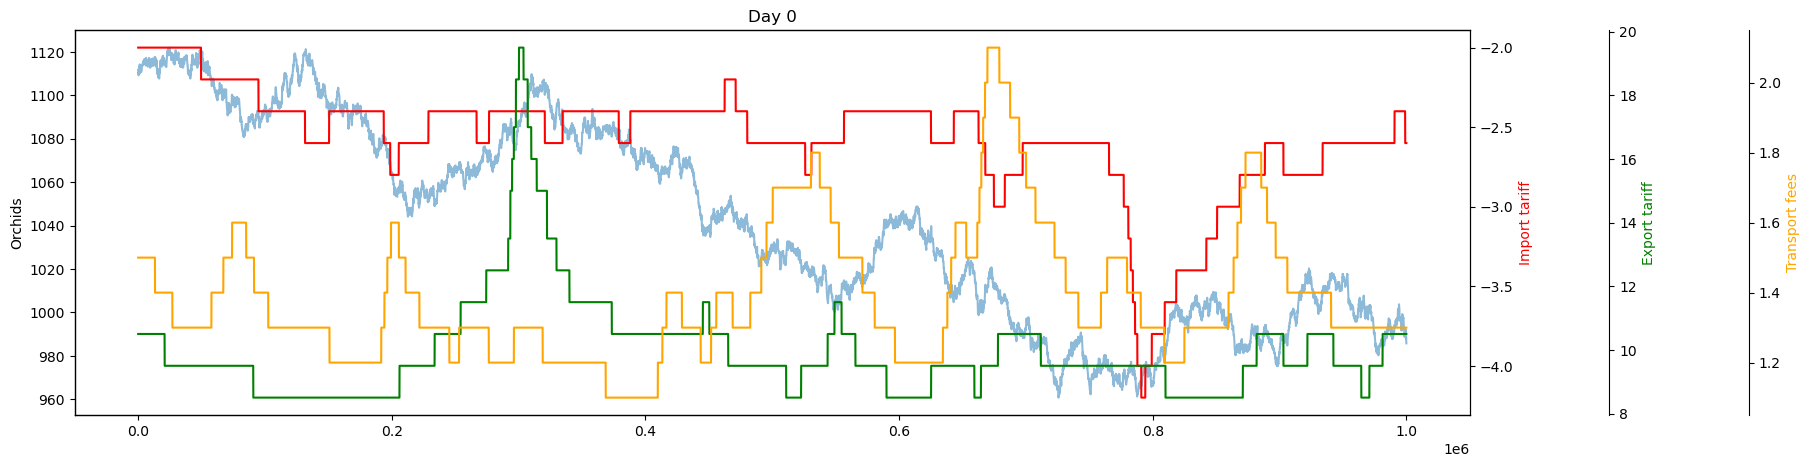

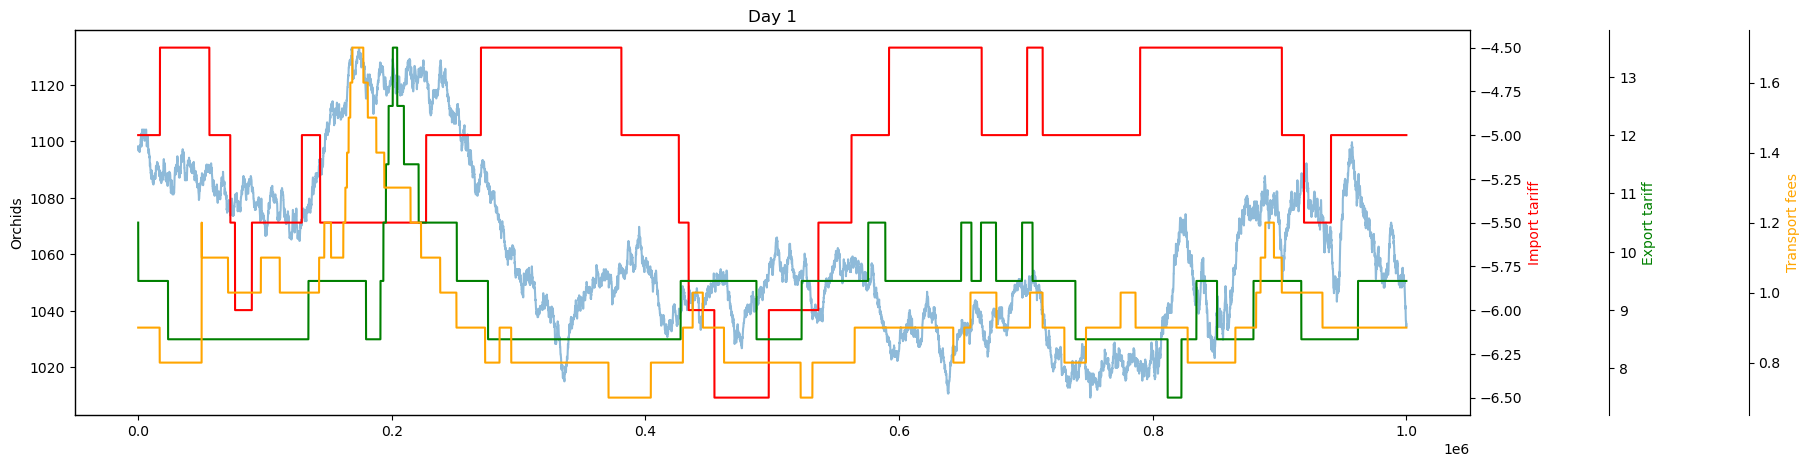

In [6]:
for d in days:
    fig, ax1 = plt.subplots(figsize=(18, 5))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()
    ax3.spines.right.set_position(("axes", 1.1))
    ax4.spines.right.set_position(("axes", 1.2))

    ax1.plot(activity.loc[d]['ORCHIDS'], alpha=0.5)
    ax1.set_ylabel('Orchids')
    
    ax2.plot(activity.loc[d]['IMPORT_TARIFF'], color='red')
    ax2.set_ylabel('Import tariff', color='red')

    ax3.plot(activity.loc[d]['EXPORT_TARIFF'], color='green')
    ax3.set_ylabel('Export tariff', color='green')

    ax4.plot(activity.loc[d]['TRANSPORT_FEES'], color='orange')
    ax4.set_ylabel('Transport fees', color='orange')

    plt.title(f'Day {d}')
    plt.show()

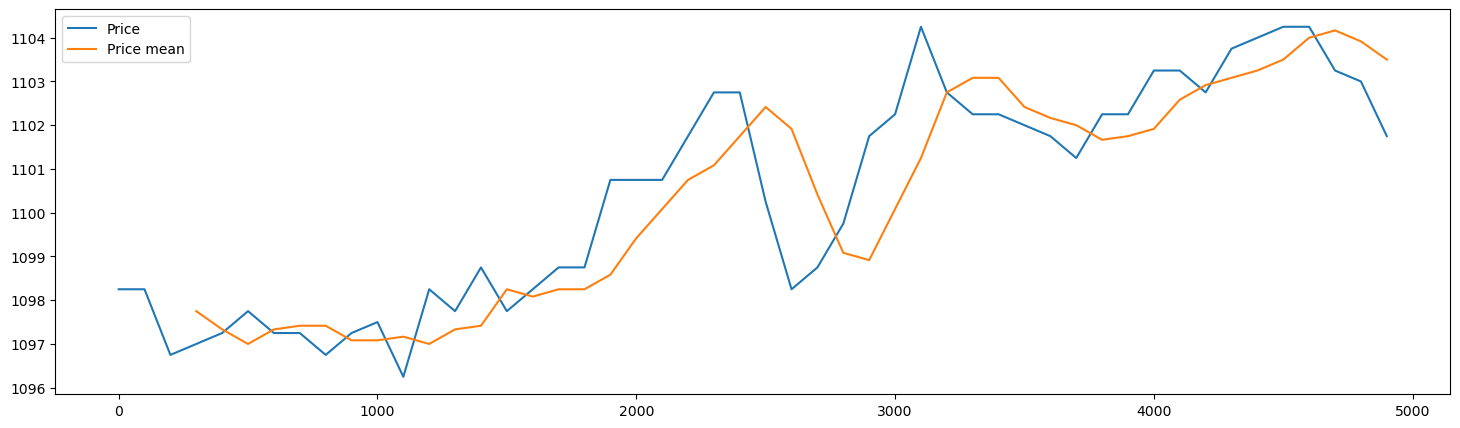

In [7]:
num_data = 3
d = 1

price = activity.loc[d].ORCHIDS
price_mean = price.rolling(num_data).mean().shift(1)

plt.figure(figsize=(18, 5))
plt.plot(price[:50], label='Price')
plt.plot(price_mean[:50], label='Price mean')
plt.legend()
plt.show()

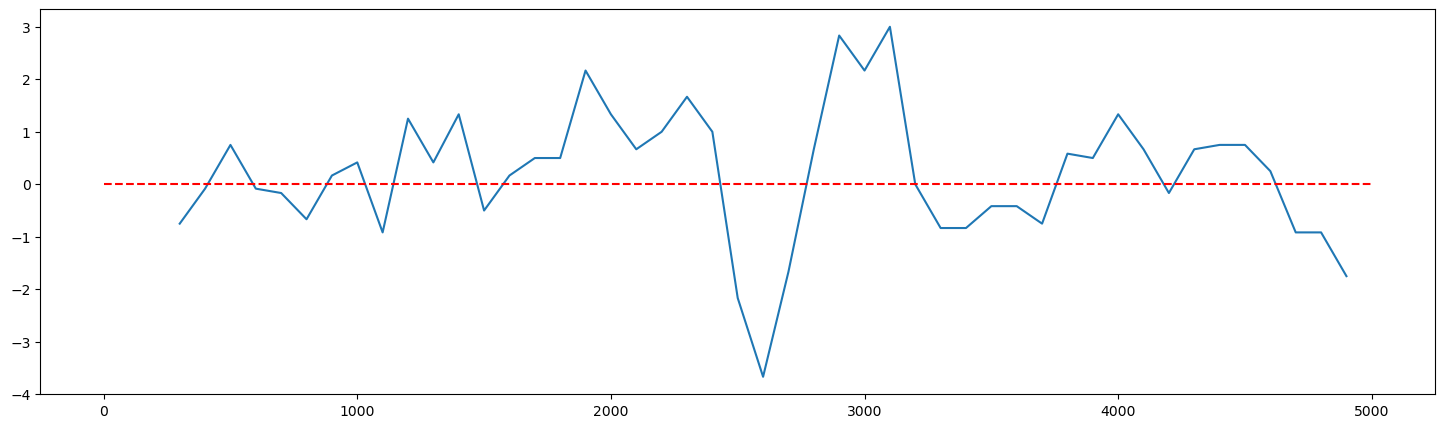

In [8]:
plt.figure(figsize=(18, 5))
plt.plot((price - price_mean)[:50])
plt.hlines(0, 0, price.index[50], color='red', linestyle='dashed')
plt.show()

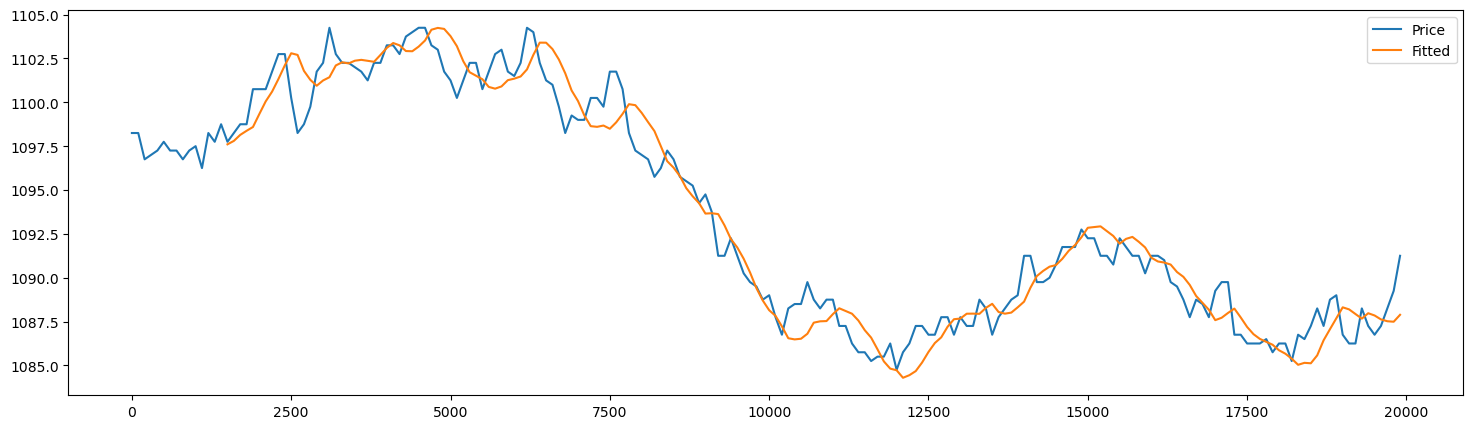

In [9]:
fitted_price = pd.Series(index=price.index)
num_data = 15

for i in range(num_data, len(price)):
    history = price[i-num_data:i].values
    model = np.polyfit(range(num_data), history, 1)
    fitted_price.iloc[i] = np.polyval(model, num_data)

plt.figure(figsize=(18, 5))
plt.plot(price[:200], label='Price')
plt.plot(fitted_price[:200], label='Fitted')
plt.legend()
plt.show()

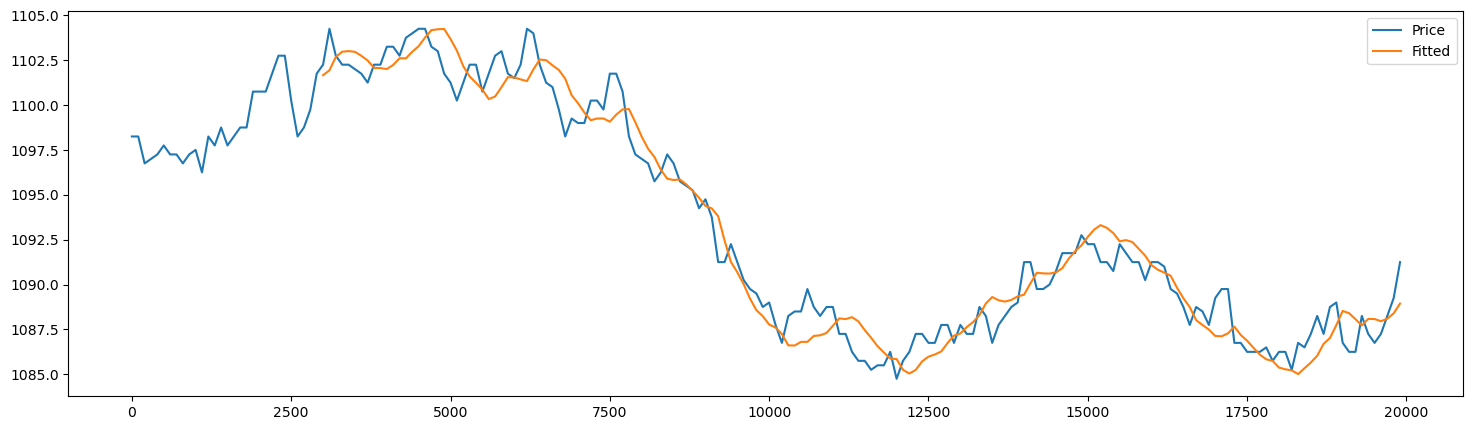

In [10]:
fitted_price = pd.Series(index=price.index)
num_data = 30

for i in range(num_data, len(price)):
    history = price[i-num_data:i].values
    model = np.polyfit(range(num_data), history, 2)
    fitted_price.iloc[i] = np.polyval(model, num_data)

plt.figure(figsize=(18, 5))
plt.plot(price[:200], label='Price')
plt.plot(fitted_price[:200], label='Fitted')
plt.legend()
plt.show()

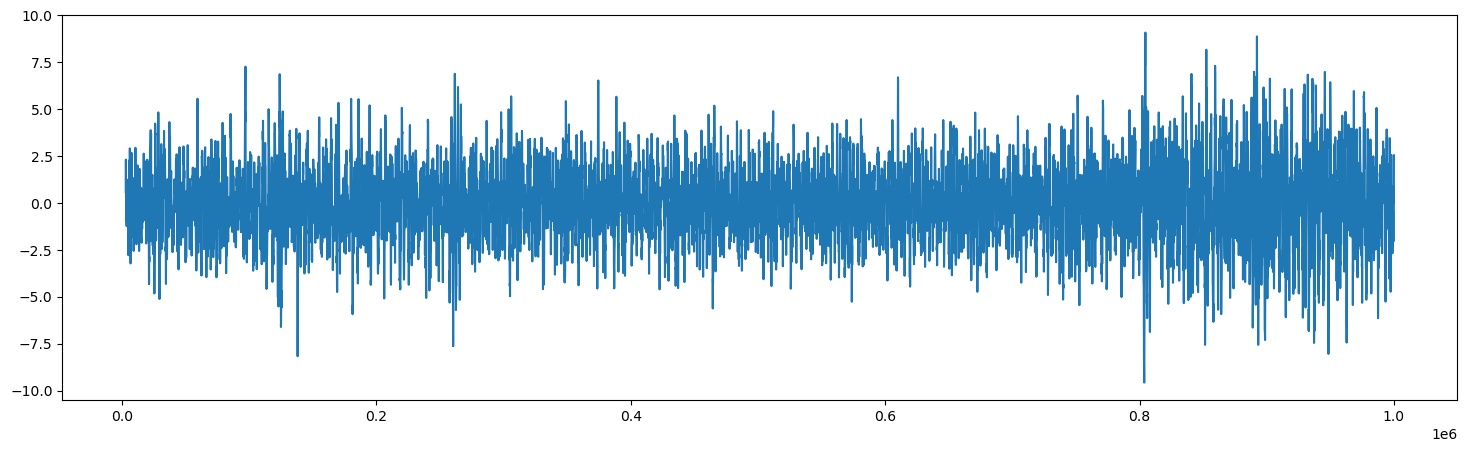

In [11]:
plt.figure(figsize=(18, 5))
plt.plot((price - fitted_price))
# plt.hlines(0, 0, price.index, color='red', linestyle='dashed')
plt.show()

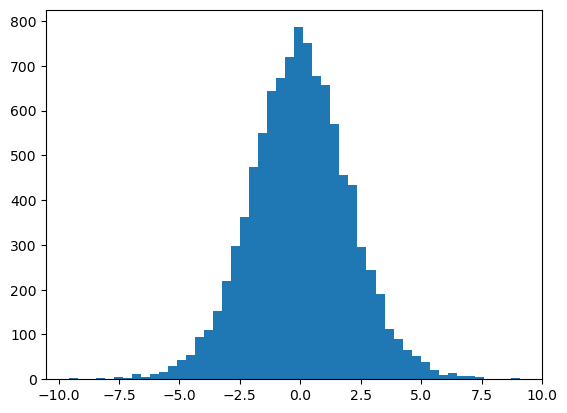

In [12]:
plt.hist((price - fitted_price).dropna(), bins=50)
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error

poly_degs = [1, 2, 3]
num_data = [5, 10, 15, 20, 25, 30]
best = float('inf')
res = None

for deg in poly_degs:
    for num in num_data:
        fitted_price = pd.Series(index=price.index)

        for i in range(num, len(price)):
            history = price[i-num:i].values
            model = np.polyfit(range(num), history, deg)
            fitted_price.iloc[i] = np.polyval(model, num)
        
        mse = np.sqrt(mean_squared_error(price[num:], fitted_price[num:]))
        if mse < best:
            best = mse
            res = (deg, num)
        print(f'Degree {deg}, num data {num}: {mse}')

Degree 1, num data 5: 1.3653360051513974
Degree 1, num data 10: 1.5814661933400584
Degree 1, num data 15: 1.8038977828246852
Degree 1, num data 20: 2.0171701757641824
Degree 1, num data 25: 2.2058520524653664
Degree 1, num data 30: 2.3907854613379955
Degree 2, num data 5: 1.7888733960822658
Degree 2, num data 10: 1.6263319290115161
Degree 2, num data 15: 1.702832845440215
Degree 2, num data 20: 1.8202287612315011
Degree 2, num data 25: 1.9516522306432365
Degree 2, num data 30: 2.0615617890893216
Degree 3, num data 5: 3.265795985570393
Degree 3, num data 10: 1.9687342513055812
Degree 3, num data 15: 1.853172298637573
Degree 3, num data 20: 1.858573415092116
Degree 3, num data 25: 1.9213191164062544
Degree 3, num data 30: 2.006908610449629


In [14]:
best, res

(1.3653360051513974, (1, 5))

In [15]:
ask, ask_amount = 1093, -8
bid, bid_amount = 1086, 8
ask_foreign = 1090
expected_mid_price = 1090
position = -49
s = [3, 0.75]
POS_LIMIT = 100

import_fee = -3.7

c1 = expected_mid_price - (ask_foreign + import_fee) - s[0]
c2 = expected_mid_price - ask - s[0]
c3 = bid - expected_mid_price - (s[1] + import_fee)

best = -float('inf')
for i in range(max(1, 1 - position)):
    for j in range(min(POS_LIMIT - position, -ask_amount + 1)):
        for k in range(min(POS_LIMIT + position, bid_amount + 1)):
            if c1*i + c2*j + c3*k - 0.1*max(0, position + i + j - k) > best:
                best = c1*i + c2*j + c3*k - 0.1*max(0, position + i + j - k)
                conversions = i
                buy_amount = j
                sell_amount = k

i, j, k, best

(49, 8, 8, 34.30000000000223)